# **Detectação de suportes e resistências nos preços dos ativos usando machine learning (K-means Clustering)**

---

*Disclaimer:*

Este código foi elaborado para fins exclusivamente educacionais. O conteúdo aqui apresentado visa fornecer informações complementares para auxiliar o investidor na tomada de suas próprias decisões de investimento. Reforçando, nenhum tópico aqui abordado constitui qualquer tipo de indicação de compra/venda de qualquer ativo financeiro.

---

## Definição do problema:

Detectar suportes e resistências de forma automatizada em múltiplos ativos para avaliar potenciais pontos de compras/vendas

Neste código, apresento uma ferramenta para detectar suportes e resistências nos preços de ativos utilizando o método de agrupamento K-means (aprendizado de máquina não supervisionado). O código está dividido em dois tópicos:

1) Exploração da técnica;
2) Screening de múltiplos ativos que estejam próximos à suportes ou resistências considerando seus preços atuais.

Contexto:

A definição de suportes e resistências nos preços dos ativos busca identificar regiões com boas razões risco/retorno. Os suportes são níveis de preço em que um ativo tende a parar de cair (piso) e pode começar a subir. Já as resistências indicam níveis de preço onde um ativo tende a parar de subir (teto) e pode começar a cair. Uma vez rompido, um suporte torna-se uma resistência e vice-versa.

Dessa forma, encontrado um suporte/resistência, o investidor pode comprar (suporte) ou vender (resistência) um ativo esperando que a partir daquele ponto haverá uma reversão nos preços, definindo ordens de stop-loss mais curtas (ligeiramente abaixo do suporte ou acima da resistência) para limitar perdas caso o preço não "respeite" as regiões definidas.

Mais detalhes sobre as definições e projeções de suportes e resistências pode ser encontrado em:
https://www.investopedia.com/trading/support-and-resistance-basics/

## 1. Exploração da técnica

### 1.1. Bibliotecas

In [1]:
# Manipulação de dados
import numpy as np
import pandas as pd
import datetime
import random
import itertools

# Preços dos ativos
import yfinance as yf

# Machine learning
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Visualização
import matplotlib.pyplot as plt
import mplfinance as mpf

### 1.2. Obtenção e manipulação dos dados

In [2]:
ticker = '^BVSP'
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=729)
end_date = end_date.strftime('%Y-%m-%d')
start_date = start_date.strftime('%Y-%m-%d')

df_stock = yf.download(tickers=ticker, interval='1h', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Nesta célula, travarei as datas para as que utilizei no estudo apenas para que os comentários das análises 
#sejam replicáveis no futuro considerando o mesmo dataset

#df_stock = yf.download(tickers=ticker, interval='1h', start='2022-07-05', end='2024-07-03')

A figura a seguir ilustra um exemplo dessa metodologia nos preços do IBOV e timeframe de 1h considerando os últimos 2 anos. Inicialmente, observe como o preço tem dificuldades de ficar acima dos 115000 pontos (atuando como resistência) no primeiro período dos dados(jul 2022 a jul 2023). No segundo ano (jul 2023 a jul 2024), os mesmo 115000 pontos se transformaram em um suporte interessante. Mas o desafio é, como determinar essas regiões de forma automatizada?

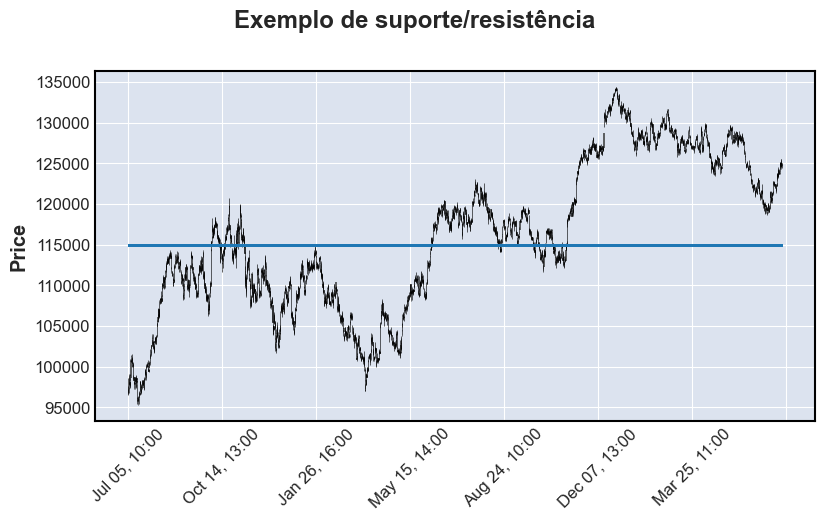

In [15]:
mpf.plot(df_stock, type='candle', hlines=[115000], title="Exemplo de suporte/resistência", figsize=(10,5), warn_too_much_data=10000)

Agora usaremos a primeira metade dos dados (mais antigos) para estabelecer suportes e resistencias. Posteriormente usaremos a segunda metade (preços mais atuais) para checar se os suportes e resistências anteriores funcionaram. Para isso precisamos checar quantos candles compõe o dataset

In [16]:
n_candles_train = round(df_stock.shape[0]/2)
X_train = np.array(df_stock.iloc[:n_candles_train]['Close'])
X_test = np.array(df_stock.iloc[n_candles_train:]['Close'])

### 1.3. Agrupamento K-means

Para conhecer o número "ideal" de grupos, utilizaremos a análise de Silhueta. Este método medirá o quão semelhante são os preço de fechamento dentro do próprio cluster quanto suas diferenças com os demais clusters. Dessa forma, maiores valores de silhueta determinam o número de clusters que utilizaremos para definir os canais de suportes e resistências. Aqui, utilizamos de 2 a 10 grupos

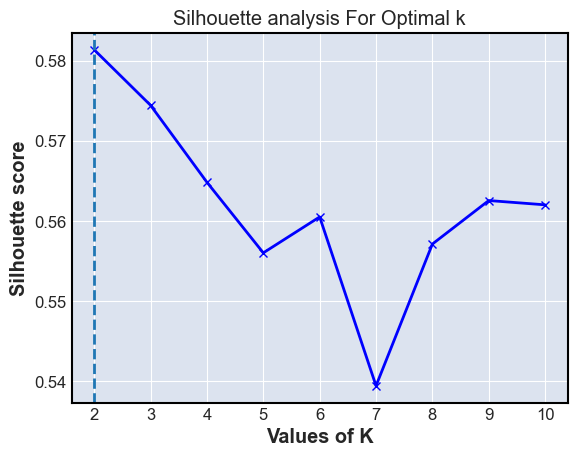

In [17]:
range_n_clusters = range(2,11)
silhouette_avg = []
for num_clusters in range_n_clusters:

    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_train.reshape(-1,1))
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(X_train.reshape(-1,1), cluster_labels))
    
max_silhouette_index =silhouette_avg.index(max(silhouette_avg))+min(range_n_clusters)
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.axvline(x=max_silhouette_index,ls='--' )
plt.show()

A figura acima mostra que utilizar dois grupos apresenta os maiores valores de silhueta. Assim, utilizaremos esse valor para executar o método de agrupamento K-means e gerar os níveis de preço que determinarão os suportes e resistências de cada cluster

In [18]:
kmeans = KMeans(n_clusters= max_silhouette_index).fit(X_train.reshape(-1,1))
c = kmeans.predict(X_train.reshape(-1,1))
minmax = []
for i in range(max_silhouette_index):
    minmax.append([-np.inf,np.inf])
for i in range(len(X_train)):
    cluster = c[i]
    if X_train[i] > minmax[cluster][0]:
        minmax[cluster][0] = X_train[i]
    if X_train[i] < minmax[cluster][1]:
        minmax[cluster][1] = X_train[i]

minmax

[[120418.15625, 107629.75], [107626.2109375, 95370.96875]]

Por fim, plotaremos os dados de fechamento com todo o dataset. A primeira metade, usada para definição dos suportes e resistências estão coloridos, bem como as linhas definidas pela análise. Os pontos em preto são da segunda metade dos dados (mais recentes). Note como a resistência definida próxima de 120000 pontos funcionou bem no ínicio da segunda metade dos dados (boa venda). Depois foi rompida com muita força, quando o preço andou quase 15000 pontos. Na porção final do gráfico, a resistência se tornou um bom suporte, revertendo a última tendência de queda.

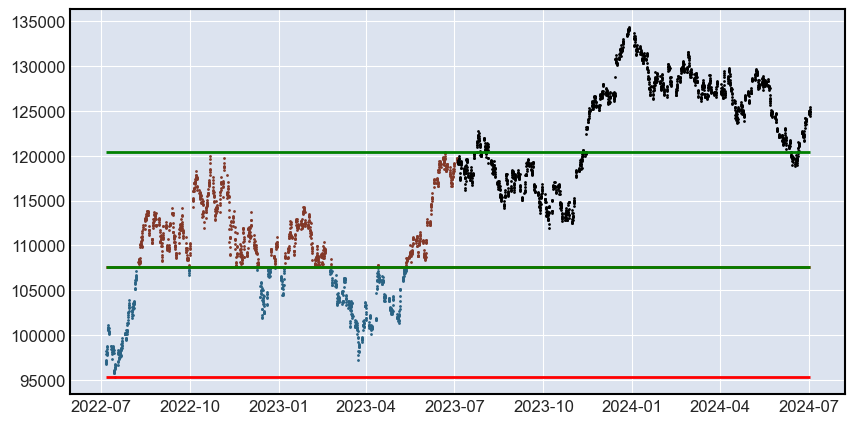

In [19]:
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(max_silhouette_index)]
colors = get_colors(max_silhouette_index)

plt.figure(figsize=(10, 5))

for i in range(len(X_train)):
    c = kmeans.predict(X_train[i].reshape(-1,1))[0]
    color = colors[c]
    plt.scatter(df_stock.index[i], X_train[i], c=color, s=1)

for i in range(len(minmax)):
    plt.hlines(minmax[i][0], xmin=df_stock.index[0], xmax=df_stock.index[-1], colors = 'g')
    plt.hlines(minmax[i][1], xmin=df_stock.index[0], xmax=df_stock.index[-1], colors = 'r')

plt.scatter(df_stock.index[len(X_train):], df_stock['Close'].iloc[len(X_train):], c='black', s=1)

## 2. Screening de ativos

Faremos o screening (varredura) utilizando todos os ativos que compõe o IBOV nesta data (03/07/2024). Calcularemos os suportes e resistências para cada um e posteriormente checaremos quais estão com os preços atuais mais próximo de algum desses pontos

In [20]:
tickers_ibov = ['ABEV3', 'ALOS3', 'ALPA4', 'ARZZ3', 'ASAI3', 'AZUL4', 'B3SA3', 'BBAS3', 'BBDC3', 'BBDC4', 
                'BBSE3', 'BEEF3', 'BPAC11', 'BRAP4', 'BRFS3', 'BRKM5', 'CCRO3', 'CIEL3', 'CMIG4', 'CMIN3', 
                'COGN3', 'CPFE3', 'CPLE6', 'CRFB3', 'CSAN3', 'CSNA3', 'CVCB3', 'CYRE3', 'DXCO3', 'EGIE3', 
                'ELET3', 'ELET6', 'EMBR3', 'ENEV3', 'ENGI11', 'EQTL3', 'EZTC3', 'FLRY3', 'GGBR4', 'GOAU4', 
                'HAPV3', 'HYPE3', 'IGTI11', 'IRBR3', 'ITSA4', 'ITUB4', 'JBSS3', 'KLBN11', 'LREN3', 'LWSA3', 
                'MGLU3', 'MRFG3', 'MRVE3', 'MULT3', 'NTCO3', 'PCAR3', 'PETR3', 'PETR4', 'PETZ3', 'PRIO3', 
                'RADL3', 'RAIL3', 'RAIZ4', 'RDOR3', 'RECV3', 'RENT3', 'RRRP3', 'SANB11', 'SBSP3', 'SLCE3', 
                'SMTO3', 'SOMA3', 'SUZB3', 'TAEE11', 'TIMS3', 'TOTS3', 'TRPL4', 'UGPA3', 'USIM5', 'VALE3', 
                'VAMO3', 'VBBR3', 'VIVA3', 'VIVT3', 'WEGE3', 'YDUQ3']

tickers_ibov = [i + '.SA' for i in tickers_ibov]

end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=729)
end_date = end_date.strftime('%Y-%m-%d')
start_date = start_date.strftime('%Y-%m-%d')

ls_df_stocks = []
for i in tickers_ibov:
    df_stock = yf.download(tickers=i, interval='1h', start=start_date, end=end_date, progress=False)
    df_stock.insert(0, 'ticker', str(i))
    ls_df_stocks.append(df_stock)

Cada item de nossa lista "ls_df_stocks" representa um dataframe com dados de abertura, máxima, mínina e fechamento (OHLC) de cada ativo da lista "tickers_ibov"

In [21]:
ls_df_stocks[0].head()

,ticker,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,,
2022-07-05 10:00:00-03:00,ABEV3.SA,13.62,14.03,13.52,14.01,14.01,0
2022-07-05 11:00:00-03:00,ABEV3.SA,14.02,14.08,13.84,13.87,13.87,3617900
2022-07-05 12:00:00-03:00,ABEV3.SA,13.87,13.94,13.78,13.91,13.91,4936700
2022-07-05 13:00:00-03:00,ABEV3.SA,13.92,13.98,13.91,13.94,13.94,2051600
2022-07-05 14:00:00-03:00,ABEV3.SA,13.94,14.06,13.94,14.04,14.04,3139600


Dividimos os dados de cada dataframe conforme explicado anteriomente

In [22]:
ls_arrays_train = []
ls_arrays_test = []

for i in ls_df_stocks:
    n_candles_train = round(i.shape[0]/2)
    X_train = np.array(i.iloc[:n_candles_train]['Close'])
    X_test = np.array(i.iloc[n_candles_train:]['Close'])
    
    ls_arrays_train.append(X_train)
    ls_arrays_test.append(X_test)

Encontramos o número de clusters "ideal" para cada ativo

In [23]:
range_n_clusters = range(2,11)

ls_max_silhouette_index = []

for i in ls_arrays_train:

    silhouette_avg = []

    for num_clusters in range_n_clusters:

        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(i.reshape(-1,1))
        cluster_labels = kmeans.labels_
        silhouette_avg.append(silhouette_score(i.reshape(-1,1), cluster_labels))
    
    max_silhouette_index = silhouette_avg.index(max(silhouette_avg))+min(range_n_clusters)
    ls_max_silhouette_index.append(max_silhouette_index)

Localizamos os suportes e resistências de cada ativo

In [24]:
if len(ls_arrays_train) == len(ls_max_silhouette_index):

    ls_minmax = []
    
    for i in range(len(ls_arrays_train)):
    
        kmeans = KMeans(n_clusters= ls_max_silhouette_index[i]).fit(ls_arrays_train[i].reshape(-1,1))
        c = kmeans.predict(ls_arrays_train[i].reshape(-1,1))
        minmax = []

        for j in range(ls_max_silhouette_index[i]):
            minmax.append([-np.inf,np.inf])

        for j in range(len(ls_arrays_train[i])):
            cluster = c[j]
            if ls_arrays_train[i][j] > minmax[cluster][0]:
                minmax[cluster][0] = ls_arrays_train[i][j]
            if ls_arrays_train[i][j] < minmax[cluster][1]:
                minmax[cluster][1] = ls_arrays_train[i][j]
        
        ls_minmax.append(minmax)

Para conferência da análise, vamos visualizar os 4 primeiros ativos da lista. Desta vez dividimos as cores dos pontos apenas em dados de treino e teste para acelerar o plot.

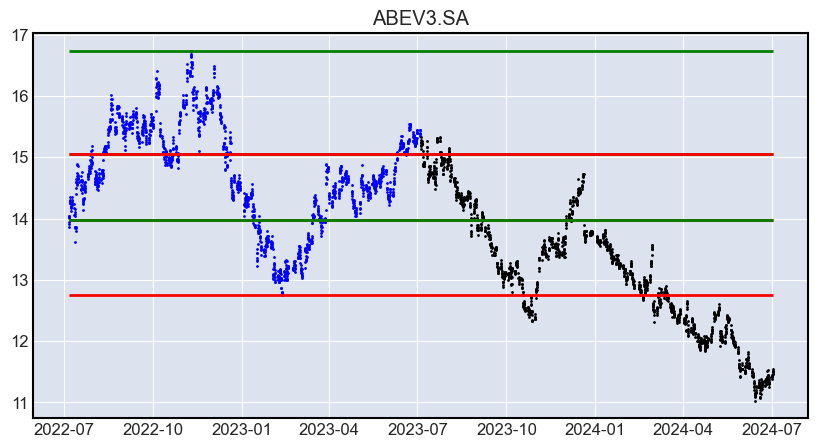

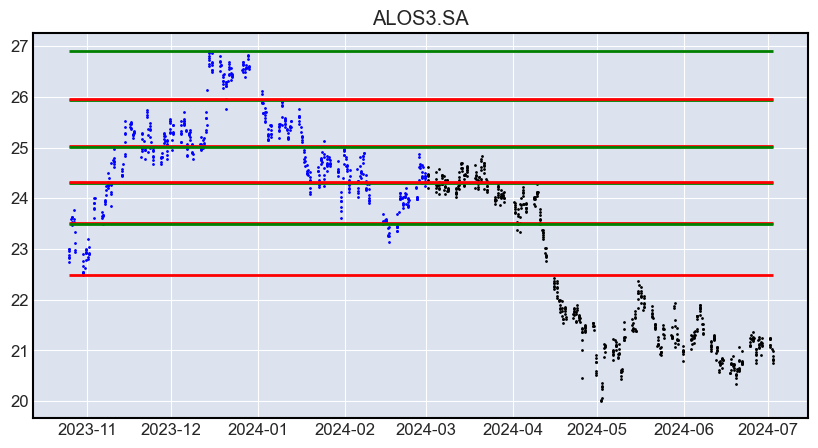

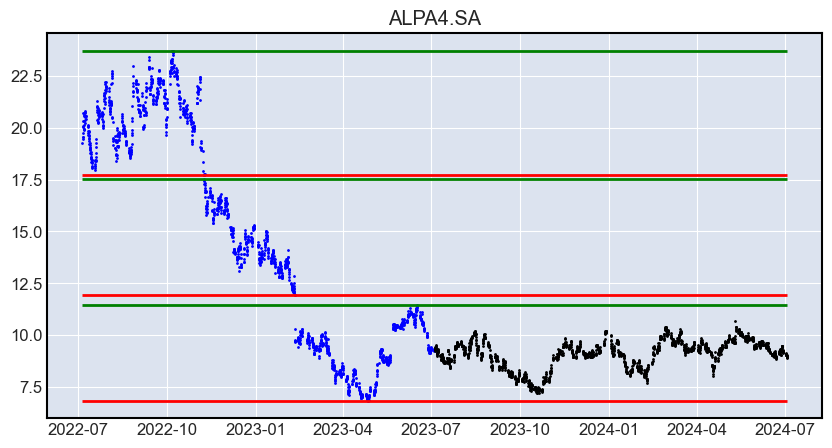

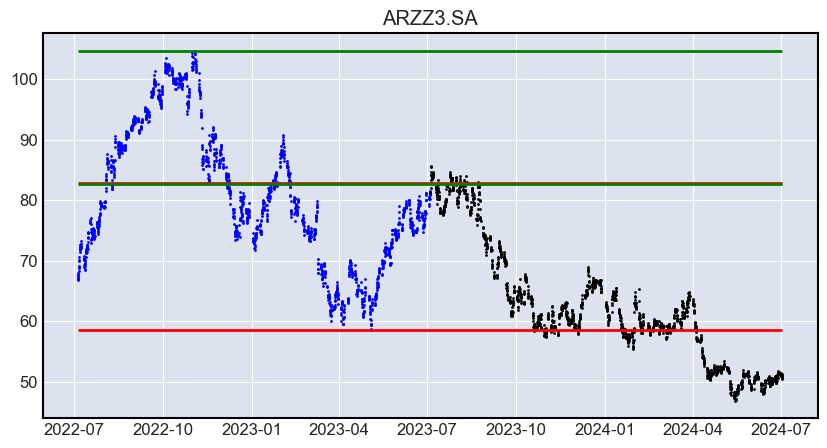

In [25]:
for stock in range(4):

    df_stock = ls_df_stocks[stock]
    X_train = ls_arrays_train[stock]
    X_test = ls_arrays_test[stock]
    max_silhouette_index = ls_max_silhouette_index[stock]
    minmax = ls_minmax[stock]

    plt.figure(figsize=(10, 5))
    plt.title(str(df_stock['ticker'].iloc[0]))

    plt.scatter(df_stock.index[:len(X_train)], df_stock['Close'].iloc[:len(X_train)], c='blue', s=1)
    plt.scatter(df_stock.index[len(X_train):], df_stock['Close'].iloc[len(X_train):], c='black', s=1)

    for i in range(len(minmax)):
        plt.hlines(minmax[i][0], xmin=df_stock.index[0], xmax=df_stock.index[-1], colors = 'g')
        plt.hlines(minmax[i][1], xmin=df_stock.index[0], xmax=df_stock.index[-1], colors = 'r')

Por fim, geraremos um dataframe com o resultado do screening baseado na proximidade dos preços atuais de algum suporte ou resistência

In [26]:
dict_screen = {'ticker':[], 'actual_price':[], 'closest_sup_res':[], 'abs_distance_(%)':[]}

for i in range(len(ls_minmax)):
    merged_minmax = list(itertools.chain(*ls_minmax[i]))
    last_price = ls_arrays_test[i][-1]
    take_closest = min(merged_minmax, key=lambda x:abs(x-last_price))
    dict_screen['ticker'].append(str(ls_df_stocks[i]['ticker'].iloc[0]))
    dict_screen['actual_price'].append(last_price)
    dict_screen['closest_sup_res'].append(take_closest)
    dict_screen['abs_distance_(%)'].append(abs(round((last_price-take_closest)/take_closest*100, 2)))

In [27]:
df_screening = pd.DataFrame.from_dict(dict_screen, orient='columns')
df_screening.sort_values(by='abs_distance_(%)', inplace=True)
df_screening

,ticker,actual_price,closest_sup_res,abs_distance_(%)
69,SLCE3.SA,19.200001,19.210743,0.06
18,CMIG4.SA,10.100000,10.092308,0.08
47,KLBN11.SA,21.740000,21.718182,0.10
21,CPFE3.SA,32.759998,32.830002,0.21
84,WEGE3.SA,42.150002,42.250000,0.24
...,...,...,...,...
58,PETZ3.SA,3.690000,5.530000,33.27
14,BRFS3.SA,23.629999,17.650000,33.88
50,MGLU3.SA,12.170000,20.699999,41.21
32,EMBR3.SA,36.570000,21.080000,73.48


Podemos visualizar os três ativos com preço atual mais próximo de algum suporte/resistência

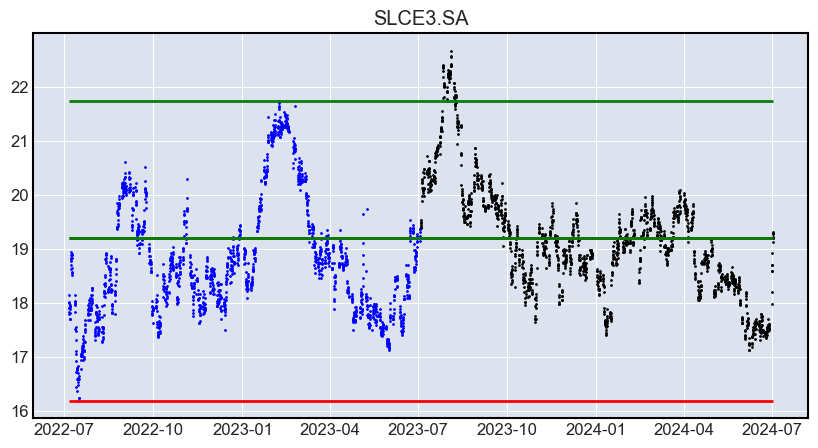

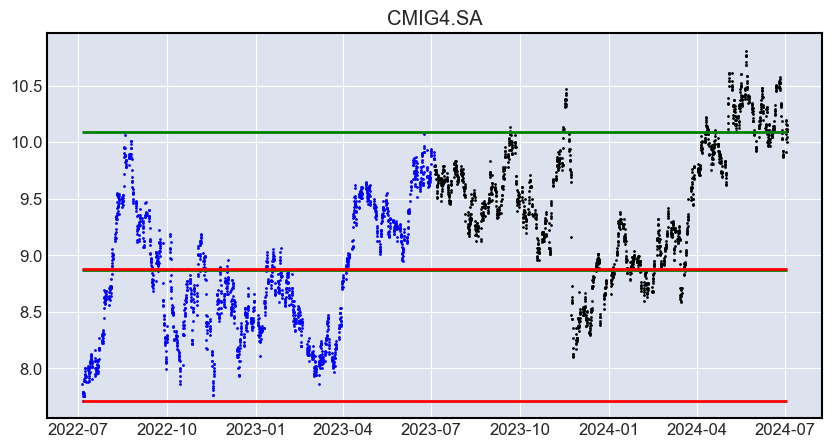

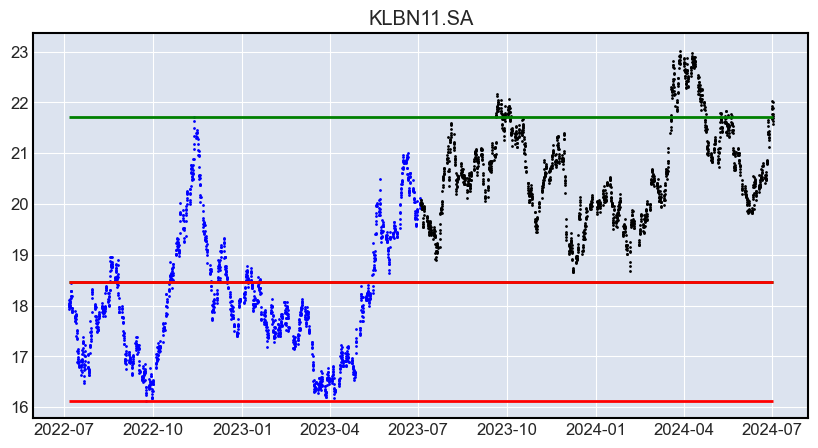

In [28]:
for stock in df_screening.index[0:3]:
    df_stock = ls_df_stocks[stock]
    X_train = ls_arrays_train[stock]
    X_test = ls_arrays_test[stock]
    max_silhouette_index = ls_max_silhouette_index[stock]
    minmax = ls_minmax[stock]

    plt.figure(figsize=(10, 5))
    plt.title(str(df_stock['ticker'].iloc[0]))

    plt.scatter(df_stock.index[:len(X_train)], df_stock['Close'].iloc[:len(X_train)], c='blue', s=1)
    plt.scatter(df_stock.index[len(X_train):], df_stock['Close'].iloc[len(X_train):], c='black', s=1)

    for i in range(len(minmax)):
        plt.hlines(minmax[i][0], xmin=df_stock.index[0], xmax=df_stock.index[-1], colors = 'g')
        plt.hlines(minmax[i][1], xmin=df_stock.index[0], xmax=df_stock.index[-1], colors = 'r')

Podemos visualizar os três ativos com preço atual mais distante de algum suporte/resistência

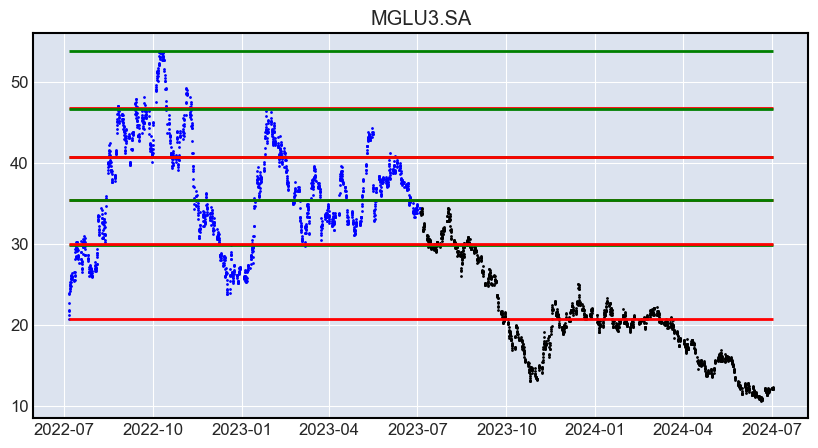

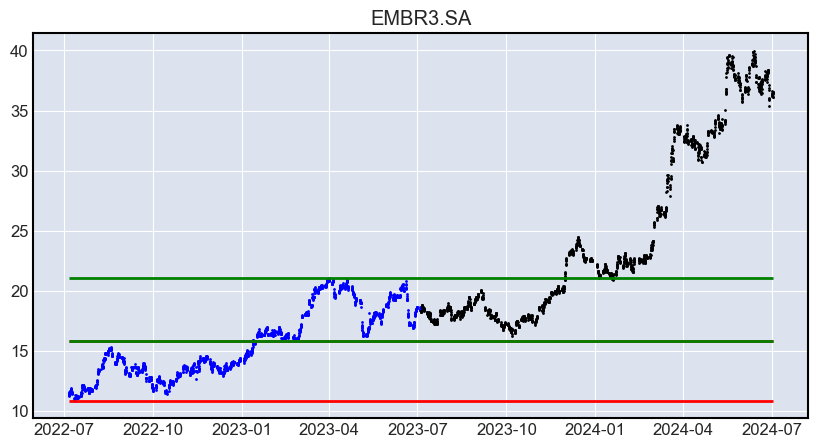

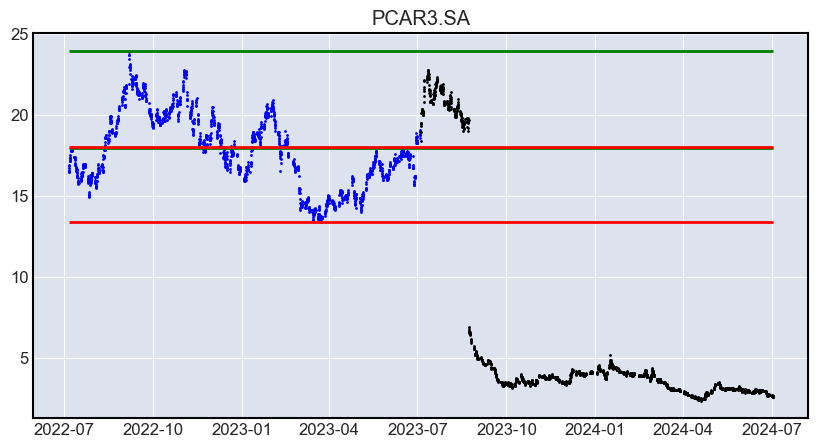

In [29]:
for stock in df_screening.index[-3:]:
    df_stock = ls_df_stocks[stock]
    X_train = ls_arrays_train[stock]
    X_test = ls_arrays_test[stock]
    max_silhouette_index = ls_max_silhouette_index[stock]
    minmax = ls_minmax[stock]

    plt.figure(figsize=(10, 5))
    plt.title(str(df_stock['ticker'].iloc[0]))

    plt.scatter(df_stock.index[:len(X_train)], df_stock['Close'].iloc[:len(X_train)], c='blue', s=1)
    plt.scatter(df_stock.index[len(X_train):], df_stock['Close'].iloc[len(X_train):], c='black', s=1)

    for i in range(len(minmax)):
        plt.hlines(minmax[i][0], xmin=df_stock.index[0], xmax=df_stock.index[-1], colors = 'g')
        plt.hlines(minmax[i][1], xmin=df_stock.index[0], xmax=df_stock.index[-1], colors = 'r')